## Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

## Data Segmentation

### Import Segmentation model

In [3]:
scaler = pickle.load(open('scaler.pickle','rb'))

pca = pickle.load(open('pca.pickle','rb'))

kmeans_pca = pickle.load(open('kmeans_pca.pickle','rb'))

### Standardization

In [4]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_purchase_seg_std = scaler.transform(features)

### PCA 

In [5]:
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

### K-means PCA

In [6]:
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

df_purchase_predictors = df_purchase.copy()

df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

In [7]:
segment_dummies = pd.get_dummies(df_purchase_seg_kmeans_pca,
                                prefix = 'Segement',
                                prefix_sep='_')
df_purchase_predictors = pd.concat([df_purchase_predictors,
                                  segment_dummies], axis=1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [8]:
Y = df_pa['Incidence']

In [9]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

In [10]:
model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X,Y)

LogisticRegression(solver='sag')

In [11]:
model_purchase.coef_

array([[-2.34808711]])

### Price Elasticity of Purchase Probability

In [12]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [13]:
price_range = np.arange(0.5,3.5,0.01)

df_price_range = pd.DataFrame(price_range)

In [14]:
df_price_e = pd.DataFrame(price_range)
df_price_e = df_price_e.rename(columns = {0:'Price_point'})

$Elasticity = {\frac {\frac{\delta Pr(purchase)}{Pr(purchase)}} {\frac{\delta Price}{Price}}} $


$ Elasticity = {\beta} * price * (1- Pr(purchase) $

### Purchase Probalities by Segment

In [15]:
def plot_elasticity(df, price_range, df_price_range, df_price_e):
    
    col_name = ''
    for i in range(-1,4):
        if i != -1:
            temp = df[df['Segment'] == i]
            col_name = 'PE_S'+str(i)
        else:
            temp = df
            col_name = 'PE_ALL'

        Y = temp['Incidence']

        X = pd.DataFrame()
        X['Mean_Price'] = (temp['Price_1'] +
                           temp['Price_2'] +
                           temp['Price_3'] +
                           temp['Price_4'] +
                           temp['Price_5']) / 5

        model_purchase = LogisticRegression(solver='sag')
        model_purchase.fit(X,Y)

        Y_pr = model_purchase.predict_proba(df_price_range)
        purchase_pr = Y_pr[:][:,1]

        pe = model_purchase.coef_[:,0] * price_range * (1 - purchase_pr)

        df_price_e[col_name] = pe

    return df_price_e

temp_df = plot_elasticity(df_pa, price_range, df_price_range, df_price_e)

In [16]:
temp_df.iloc[70:97,:]

,Price_point,PE_ALL,PE_S0,PE_S1,PE_S2,PE_S3
70,1.20,-0.891388,-0.686274,-0.997187,-0.702439,-0.804378
71,1.21,-0.913305,-0.699208,-1.012957,-0.713016,-0.835002
72,1.22,-0.935585,-0.712294,-1.028843,-0.723674,-0.866561
73,1.23,-0.958228,-0.725532,-1.044844,-0.734414,-0.899067
74,1.24,-0.981234,-0.738923,-1.060959,-0.745235,-0.932537
75,1.25,-1.004604,-0.752467,-1.077185,-0.756136,-0.966984
76,1.26,-1.028336,-0.766163,-1.093523,-0.767118,-1.002421
77,1.27,-1.052431,-0.780012,-1.109971,-0.778180,-1.038860
78,1.28,-1.076889,-0.794014,-1.126527,-0.789321,-1.076313
79,1.29,-1.101707,-0.808167,-1.143191,-0.800542,-1.114791


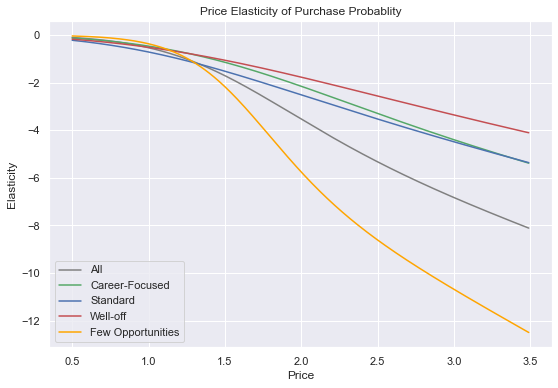

In [17]:
plt.figure(figsize=(9,6))
plt.plot(price_range, temp_df['PE_ALL'], color='grey')
plt.plot(price_range, temp_df['PE_S0'], color='g')
plt.plot(price_range, temp_df['PE_S1'], color='b')
plt.plot(price_range, temp_df['PE_S2'], color='r')
plt.plot(price_range, temp_df['PE_S3'], color='orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probablity')
plt.legend(['All','Career-Focused','Standard','Well-off','Few Opportunities'])
plt.show()

***Price points till the elasticity is inelastic for all and by segments***

1. All Customers = 1.25
2. Career-Focused = 1.42
3. Standard = 1.21
4. Well-off = 1.46
5. Few-Opportunites = 1.26

*P.S - the figures are in dollars.*

### Purchase Probability with Promotion Feature

In [18]:
Y = df_pa['Incidence']

In [19]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                   df_pa['Promotion_2'] +
                   df_pa['Promotion_3'] +
                   df_pa['Promotion_4'] +
                   df_pa['Promotion_5']) / 5

In [42]:
model_promotion = LogisticRegression(solver='sag')
model_promotion.fit(X,Y)
model_promotion.coef_

array([[-1.49407954,  0.56149371]])

### Price Elasticity with Promotion

In [37]:
df_price_e_prom = pd.DataFrame(price_range)
df_price_e_prom = df_price_e_prom.rename(columns = {0:'Price_Range'})

df_price_e_prom['Promotion'] = 1

#Purchase Probability with Promotion Model Prediction
Y_prom = model_promotion.predict_proba(df_price_e_prom)

promo = Y_prom[:,1]
pe_prom = (model_promotion.coef_[:,0]*price_range)*(1-promo)

# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_e['Promotion'] = pe_prom

### Price Elasticity without Promotion

In [33]:
df_price_e_no_prom = pd.DataFrame(price_range)
df_price_e_no_prom = df_price_e_no_prom.rename(columns = {0: "Price_Range"})

df_price_e_no_prom['Promotion'] = 0

#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_promotion.predict_proba(df_price_e_no_prom)

no_promo = Y_no_promo[:,1]
pe_no_promo = model_promotion.coef_[:,0]*price_range*(1-no_promo)

# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_e['No_Promotion'] = pe_no_promo

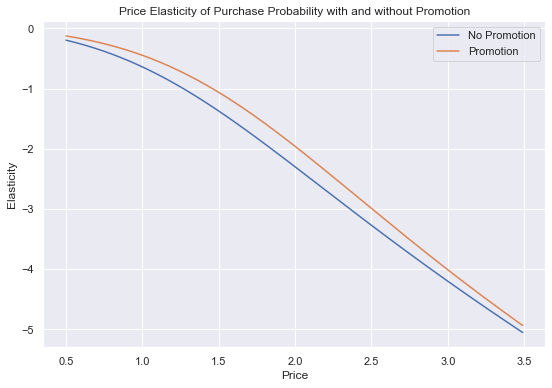

In [38]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe_no_promo)
plt.plot(price_range, pe_prom)
plt.legend(['No Promotion','Promotion'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

### Analysis
1. *Customers are less price sensitive to price changes when there are promotion activities.*
2. *It would be more beneficial to have a higher original price and constant promotion.*